In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import investpy
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Download stock data

In [ ]:
all_stocks = investpy.get_stocks_list(country='United States')
#all_stocks = investpy.etfs.get_etfs_list('united states')
print('There are {} etfs'.format(str(len(all_stocks))))
stocks_selected = all_stocks[:100]
print('out of which '+  str(len(stocks_selected)) + ' are chosen')

In [3]:
#stocks_selected = ' '.join(stocks_selected)
data = yf.download(stocks_selected, start = "2010-01-02", end = "2020-09-05")

[*********************100%***********************]  100 of 100 completed


In the paper, authors drop all assets that contain at least 1 non-traded day (nan). But if we do this here, no stocks would be left at all, so we interpolate missing values

In [4]:
close = data[['Adj Close']].dropna(axis = 1, how = 'all', thresh = data.shape[0] * 0.95) #drop stock if 5% of days are absent
close = close.fillna(0)
close.columns = close.columns.droplevel(0)
close.index = pd.to_datetime(close.index)
close.index = close.index.to_period(freq='d')
print(str(close.shape[1]) + ' stocks left')

91 stocks left


In [5]:
close.head(3)

,AA,AAPL,ADBE,ADSK,AMAT,AMZN,ATLC,BA,BAC,BB,...,SPAR,STLD,T,TEVA,VIAV,VRSN,VRTX,WYNN,XRAY,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,37.018944,6.604801,37.090000,25.670000,11.516642,133.899994,3.30,43.441975,13.816905,65.930000,...,5.092957,13.873272,15.742277,47.299187,4.812287,21.007998,44.240002,41.963718,33.034389,11.827960
2010-01-05,35.862801,6.616219,37.700001,25.280001,11.428047,134.690002,3.32,44.864773,14.266021,65.800003,...,5.493240,13.789833,15.665167,46.629093,4.829351,21.228777,42.779999,44.515926,32.641670,12.244997
2010-01-06,37.730419,6.510980,37.619999,25.340000,11.403889,132.250000,3.37,46.225727,14.433337,65.400002,...,5.927589,14.791073,15.435946,46.743496,5.073947,20.999506,42.029999,43.932011,32.856728,13.309779


In [6]:
returns = close.pct_change().iloc[1:, :]#fill_method='ffill').iloc[1:, :]
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna(axis = 0)
returns = returns.fillna(0)
returns.head(3)

,AA,AAPL,ADBE,ADSK,AMAT,AMZN,ATLC,BA,BAC,BB,...,SPAR,STLD,T,TEVA,VIAV,VRSN,VRTX,WYNN,XRAY,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.031231,0.001729,0.016446,-0.015193,-0.007693,0.005900,0.006061,0.032752,0.032505,-0.001972,...,0.078595,-0.006014,-0.004898,-0.014167,0.003546,0.010509,-0.033002,0.060819,-0.011888,0.035259
2010-01-06,0.052077,-0.015906,-0.002122,0.002373,-0.002114,-0.018116,0.015060,0.030335,0.011728,-0.006079,...,0.079070,0.072607,-0.014633,0.002453,0.050648,-0.010800,-0.017532,-0.013117,0.006588,0.086957
2010-01-07,-0.021214,-0.001848,-0.019405,0.005525,-0.010593,-0.017013,0.026706,0.040482,0.032947,-0.001529,...,-0.007184,-0.006667,-0.011228,-0.006294,0.005605,-0.013748,-0.012610,0.021356,0.013091,0.112000


### Filter with AR(1)-TGARCH(1,1,1)

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model 
from arch.univariate import ARX, GARCH, StudentsT

In [8]:
all_ret = np.full((returns.shape[0]-1, returns.shape[1]), 0, dtype = 'float64')

for col in range(returns.shape[1]):
    
    #mod = HARX(close.iloc[:599], lags = [1, 2], rescale = False)
    #mod.volatility = GARCH(p=1, o=1, q=1)
    #mod.distribution = StudentsT()
    order = 10 / returns.iloc[:, col].std()
    mod = arch_model(order * returns.iloc[:, col],
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='skewstudent')#, rescale = False)#    StudentsT') 
    mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
    all_ret[:, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
all_ret = pd.DataFrame(all_ret, index = returns.index[1:], columns = returns.columns, dtype = 'float64')

In [9]:
all_res = np.full((close.shape[0] - 1, close.shape[1]), 0,  dtype = 'float64')

for col in range(close.shape[1]):
       # mod = ARX(100 * returns.iloc[:, col], lags = [1, 2,])
       # mod.volatility = GARCH(p=1, o=1, q=1)
       # mod.distribution = StudentsT()
    """order = 0
    if (close.iloc[:, col] >= 1000).all():
        order = 0.01
    elif (close.iloc[:, col] < 1).all():
        order = 100
    else:
        order = 1"""
    order = 10 / close.iloc[:, col].std()
    mod = arch_model(order * close.iloc[:, col],
                        mean='ARX', lags = 1, # mean = Constant, ARX, HARX + the number of lags
                        vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                        dist='skewstudent')#, rescale=False)#    StudentsT') 
    mod_fit = mod.fit(options = {'maxiter':500}, disp='off',  show_warning = False)
    all_res[:, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
all_res = pd.DataFrame(all_res, index = close.index[1:], columns = close.columns, dtype = 'float64')

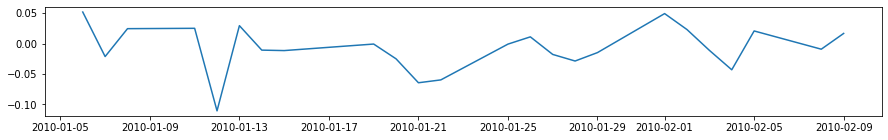

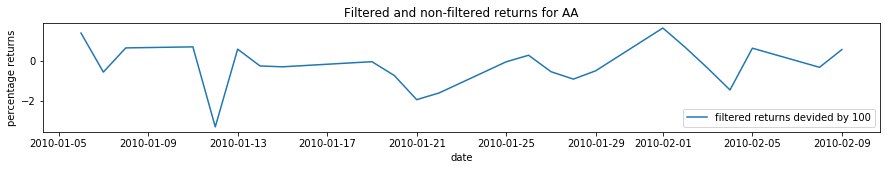

In [10]:
plt.figure(figsize = (15, 2))
plt.plot(returns.index.to_timestamp()[1:25], returns.iloc[1:25, 0], label = 'non-filtered returns');
plt.figure(figsize = (15, 2))
plt.plot(returns.index.to_timestamp()[1:25], all_ret.iloc[:24, 0], label = 'filtered returns devided by 100');
plt.title('Filtered and non-filtered returns for {}'.format(all_ret.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('percentage returns');

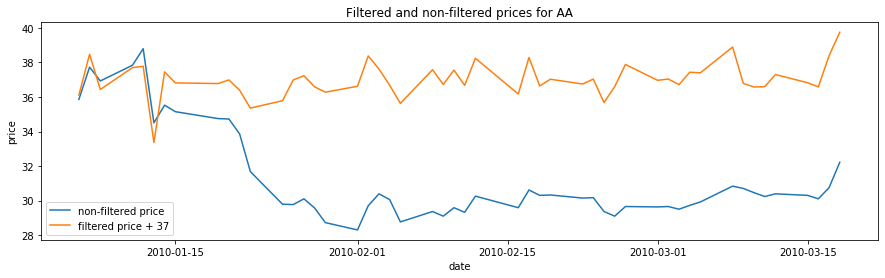

In [11]:
plt.figure(figsize = (15,4))
plt.plot(returns.index.to_timestamp()[1:51], close.iloc[1:51, 0], label = 'non-filtered price');
plt.plot(returns.index.to_timestamp()[1:51], all_res.iloc[:50, 0] + 37, label = 'filtered price + 37');
plt.title('Filtered and non-filtered prices for {}'.format(all_res.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('price');

In [12]:
#split in training, validation and test sets
#THESE ARE FILTERED PRICES
price_train = all_res.loc[:'2019-01-01', :]
price_val = all_res.loc['2019-01-01':'2020-01-01']
price_test = all_res.loc['2020-01-01':]
#THESE ARE NON-FILTERED PRICES
raw_price_train = close.loc[:'2019-01-01', :]
raw_price_val = close.loc['2019-01-01':'2020-01-01']
raw_price_test = close.loc['2020-01-01':]
# returns filtered
filt_ret = all_ret.loc[:'2019-01-01', :]

### PCA dimensionality reduction and OPTICS clustering
   The authors use 15 principal components in PCA but we use a larger number due to the fact that out time series is longer (authors had 8 years of training data) and it could be we cannot describe it well in 15 components. Then, these components serve as input to OPTICS - density based clustering method. To choose among models, we use silhouette score. It is in range between -1 and 1, the higher it is the better.

In [13]:
def find_max(silhouette):
    all_vals = []
    for val in silhouette.values():
        all_vals.extend(val)
    return all_vals

def best_params(silhouette):
    all_vals = find_max(silhouette)
    max_val = max(all_vals)
    for key, val in silhouette.items():
        if max_val in val:
            return key, val.index(max_val) + 2, max_val

In [14]:
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

silhouette = dict()
for comp in range(2, 16):
    partial_silh = list()
    pca = PCA(n_components = comp, svd_solver = 'auto')
    pca_fit = pca.fit_transform(filt_ret.transpose())
    for min_sampl in range(2, 7):
        try:
            clusters = OPTICS(min_samples = min_sampl).fit(pca_fit) #metric = 'euclidean' min_cluster_size = 5
            partial_silh.append(silhouette_score(pca_fit, clusters.labels_))
        except: pass
    silhouette[comp] = partial_silh
    
best_comp, best_min_smpl, best_score = best_params(silhouette)
print('best silhouette_score is ' + str(best_score) + ' at ' + str(best_min_smpl) + ' min_samples and ' +
      str(best_comp) + ' components')

best silhouette_score is 0.20001303795222347 at 2 min_samples and 2 components


In [15]:
pca = PCA(n_components = best_comp, svd_solver = 'auto')
pca_fit = pca.fit_transform(filt_ret.transpose())
clusters = OPTICS(min_samples = best_min_smpl).fit(pca_fit)

Number of clusters is 25


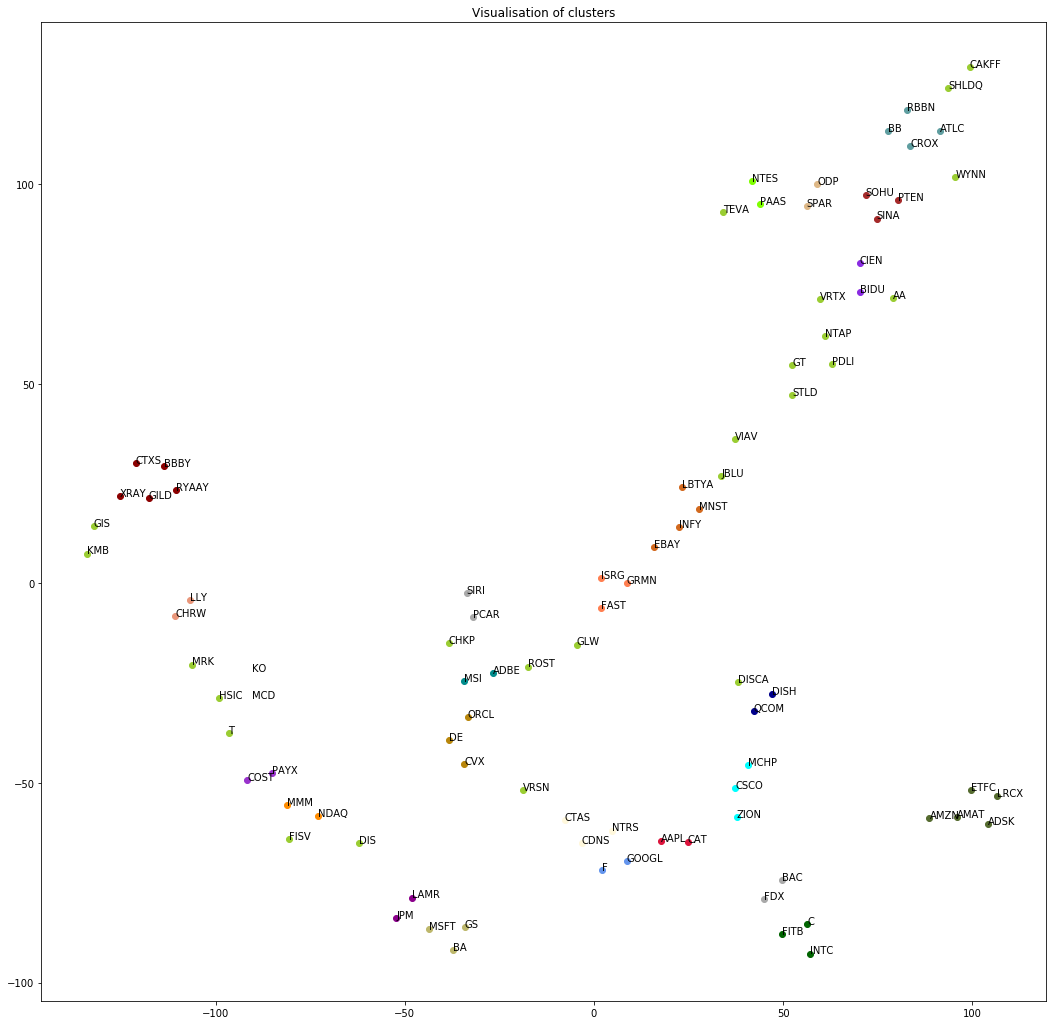

In [16]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

tsne = TSNE(n_components = 2, perplexity = 6).fit_transform(pca_fit)

print('Number of clusters is ' + str(clusters.labels_.max()-clusters.labels_.min()))
colors = list(mcolors.CSS4_COLORS.keys())[10:]
plt.figure(figsize=(18,18))
for klass in range(clusters.labels_.min(), clusters.labels_.max()):
    plt.scatter(tsne[clusters.labels_ == klass][:, 0], tsne[clusters.labels_ == klass][:, 1],
               c = colors[klass], label = 'class {}'.format(str(klass)))
for i, txt in enumerate(filt_ret.columns):
    plt.annotate(txt, (tsne[i, 0], tsne[i, 1]))
#plt.legend()
plt.title('Visualisation of clusters');

In [17]:
#do not include class -1 since these are outliers/points without claster
classes = dict()
for cl in range(0, clusters.labels_.max()): 
    klass = price_train.transpose()[clusters.labels_ == cl]
    classes[cl] = klass

### Select pairs
Next, we select pairs based on the following criteria:
- cointegration
- Hurst exponent < 0.5
- half-life of mean reversion
- average number of crossings of spread mean per year

In [18]:
from statsmodels.tsa.stattools import coint

In [19]:
pairs = list()
for cl in classes.keys():
    tested_pairs = list()
    for smpl in range(classes[cl].shape[0]):
        for smpl2 in range(classes[cl].shape[0]):
            if smpl != smpl2 and (smpl2, smpl) not in tested_pairs: #no cointegration with itself, check pair has not been tested
                tested_pairs.append((smpl2, smpl))
                cointegrated = coint(classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2, :], return_results = True)
                if cointegrated[1] < 0.05: #pvalue
                    pairs.append([classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2,:]])
#pairs = pairs[1:]#the first pair is repeated
print('There are {} pairs at this stage'.format(len(pairs)))

There are 122 pairs at this stage


In [20]:
#check spread mean-reversion
from hurst import compute_Hc

for pair in pairs:
    spread = pair[0] - pair[1]
    H, c, data = compute_Hc(spread)
    if H >= 0.5: #Brownian motion or persistent
        for ts in pair:
            pair.remove(ts)
        pairs.remove(pair)
print('There are {} pairs at this stage'.format(len(pairs)))

There are 115 pairs at this stage


In [21]:
#check mean-reversion half life
# https://letianzj.github.io/mean-reversion.html
from scipy.ndimage.interpolation import shift
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()
for pair in pairs:
    for ts_n, ts in enumerate(pair):
        ts_delta = ts - ts.shift()
        lin_reg.fit(np.array(ts.shift()[1:]).reshape(-1,1), np.array(ts_delta[1:]).reshape(-1,1)) 
        half_life = -np.log(2) / lin_reg.coef_.item()
        if half_life < 1 or half_life > 365:
            del pair[ts_n]
            pairs.remove(pair)
            break
print('There are {} pairs at this stage'.format(len(pairs)))

There are 57 pairs at this stage


In [22]:
#check that on average there are at least 12 crossings of spread mean per year
years_num  = len(returns.index.to_timestamp().year.unique())
for pair in pairs:
    spread = pair[0] - pair[1]
    crosses = 0
    for i in range(len(spread) - 1):
        if (spread[i] > spread.mean() and spread[i + 1] < spread.mean()) or (spread[i] < spread.mean() and spread[i + 1] > spread.mean()):
            crosses += 1
    if crosses < 12 * years_num:
        for ts in pair:
            pair.remove(ts)
        pairs.remove(pair)
print('There are {} pairs at this stage'.format(len(pairs)))

There are 55 pairs at this stage


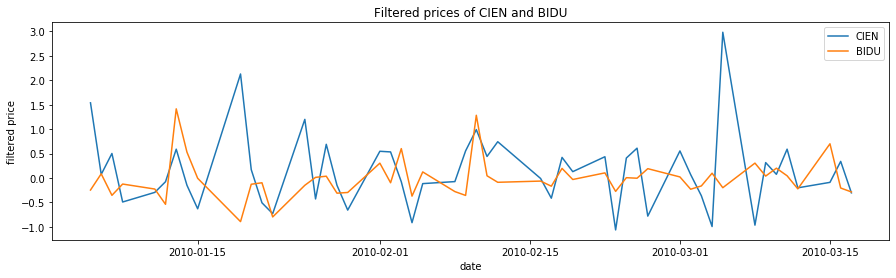

In [23]:
plt.figure(figsize = (15, 4))
plt.plot(pairs[0][0].index.to_timestamp()[:50], pairs[0][0][:50], label = pairs[0][0].name)
plt.plot(pairs[0][1].index.to_timestamp()[:50], pairs[0][1][:50], label = pairs[0][1].name)
plt.legend()
plt.xlabel('date')
plt.ylabel('filtered price')
plt.title('Filtered prices of {} and {}'.format(pairs[0][0].name, pairs[0][1].name));

C:\Users\Dell\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:805: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)
C:\Users\Dell\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:805: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


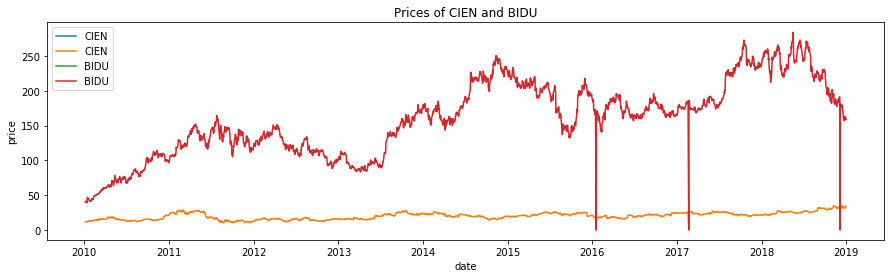

In [24]:
#Попробовать на нефильтрованных данных
plt.figure(figsize = (15, 4))
plt.plot(pairs[0][0].index.to_timestamp(), close.loc[pairs[0][0].index, ('Adj Close',pairs[0][0].name)], label = pairs[0][0].name)
plt.plot(pairs[0][1].index.to_timestamp(), close.loc[pairs[0][1].index, ('Adj Close',pairs[0][1].name)], label = pairs[0][1].name)
plt.legend()
plt.xlabel('date')
plt.ylabel('price')
plt.title('Prices of {} and {}'.format(pairs[0][0].name, pairs[0][1].name));

### Spread prediction

In [26]:
def spread_change(spread):
    spread_chg = (spread.shift(-1) - spread)[:-1]
    #spread[spread == 0] = 0.00000001 #to avoid division by zero
    spread_chg = spread_chg / spread[:-1]
    return spread_chg

In [27]:
#formation period - train set
#pairs - filtered prices but need to use ordinary ones
spread = pairs[0][0] - pairs[0][1]
spread_chg = spread_change(spread)

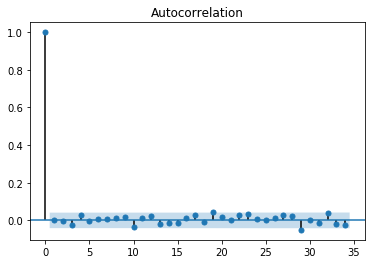

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(spread); #it is rather small, so try lags in range of 1

In [38]:
q = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
d = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

In [39]:
q

array([-1.67432371, -0.28035253])

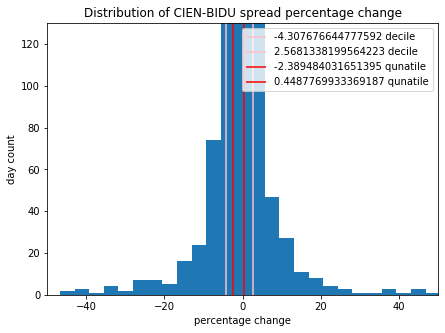

In [31]:
plt.figure(figsize=(7, 5))
plt.hist(spread_chg, bins = 500)
plt.title('Distribution of {}-{} spread percentage change'.format(pairs[0][0].name, pairs[0][1].name))
plt.xlabel('percentage change')
plt.ylabel('day count')
for dec in d:
    plt.vlines(dec, 0, 130, colors = 'pink', label = '{} decile'.format(dec))
for quant in q:
    plt.vlines(quant, 0, 130, colors = 'red', label = '{} qunatile'.format(quant))
plt.legend()
plt.xlim(-50, 50)
plt.ylim(0,130);

In [95]:
def trade(a_sh, a_lo, window, account, price_val, name1, name2):
    portfolio_value_list = []
    acc_return_list = []
    cap_invested = []
    comission = 0.001
    stock1 = 0
    stock2 = 0
    acc_return = 0.0
    prev_capital = 0.0
    prev_price1 = 0.0
    prev_price2 = 0.0
    prev_stock1 = 0
    prev_stock2 = 0
    start_idx = 0
    trade_indicator = 'no_trade'
    portfolio_value = 0
    end_idx = start_idx + window + 1 #last observation is not included
    resid = 0.0
    while end_idx <= price_val.shape[0] - 1:
        spread = price_val[name1][start_idx:end_idx] - price_val[name2][start_idx:end_idx]
        arma = ARIMA(np.array(spread), order = (1,0,1)).fit()
        pred = arma.forecast(steps=1, exog=None, alpha=0.01)
        pred_chg = (pred - spread[-1:] / spread[-1:])[0]
        
        price1 = price_val.loc[spread[-1:].index, name1][0]
        price2 = price_val.loc[spread[-1:].index, name2][0]
        if price1 < 0:
            price1 = - price1
        if price2 < 0:
            price2 = - price2
        portfolio_value = resid + stock1 * price1 + stock2 * price2 #portfolio revaluation 
        #print(resid, stock1, stock2, price1, price2)
        portfolio_value_list.append(portfolio_value)
        
        if price1 != 0 and price2 != 0: #if stock was traded
            if trade_indicator == 'short':
                acc_return += ((prev_price1 - price1)*prev_stock1 + (price2 - prev_price2)*prev_stock2) / prev_capital
            elif trade_indicator == 'long':
                acc_return += (prev_price2 - price2)*prev_stock2 + (price1 - prev_price1)*prev_price1 / prev_capital
            acc_return_list.append(acc_return)
            
            if pred_chg <= a_sh:
                trade_indicator = 'short'
                deal1 = stock1 * price1 * (1 - comission) #sell stock1
                if stock1 != 0:
                    prev_stock1 = stock1
                if deal1 > allocated_capital: 
                    stock1_to_sell = allocated_capital // (price1 * (1 - comission))
                    deal1 = stock1_to_sell * price1 * (1 - comission)
                    stock1 -= stock1_to_sell
                    if stock1_to_sell != 0:
                        prev_stock1 = stock1_to_sell
                else:
                    stock1 = 0
                account += deal1
                stock_2_bought = account // (price2 * (1 + comission))
                deal2 = stock_2_bought * price2 * (1 + comission) #buy stock2
                if deal2 > allocated_capital:
                    stock_2_bought = allocated_capital // (price2 * (1 + comission))
                    deal2 = stock_2_bought * price2 * (1 + comission)
                account -= deal2
                resid = account
                stock2 += stock_2_bought

                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_2_bought != 0:
                    prev_stock2 = stock_2_bought

            elif pred_chg >= a_lo:
                trade_indicator = 'long'
                deal2 = stock2 * price2 * (1 - comission) #sell stock2
                if stock2 != 0:
                    prev_stock2 = stock2
                if deal2 > allocated_capital:
                    stock2_to_sell = allocated_capital // (price2 * (1 - comission))
                    deal2 = stock2_to_sell * price2 * (1 - comission)
                    stock2 -= stock2_to_sell
                    if stock2_to_sell != 0:
                        prev_stock2 = stock2_to_sell
                else:
                    stock2 = 0
                account += deal2
                stock_1_bought = account // (price1 * (1 + comission))
                deal1 = stock_1_bought * price1 * (1 + comission) #buy stock1
                if deal1 > allocated_capital:
                    stock_1_bought = allocated_capital // (price1 * (1 + comission))
                    deal1 = stock_1_bought * price1 * (1 + comission)
                account -= deal1
                resid = account
                stock1 += stock_1_bought
                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_1_bought != 0:
                    prev_stock1 = stock_1_bought

            prev_price1 = price1
            prev_price2 = price2
            
        start_idx += 1
        end_idx += 1
        
    return acc_return_list, portfolio_value_list, cap_invested

def calc_returns(val_port_value, allocated_capital):
    total_returns = []
    for p in val_port_value:
            total_returns.append((p - allocated_capital) * 100 / allocated_capital)
    return total_returns
    

In [88]:
from statsmodels.tsa.arima.model import ARIMA

def find_thresholds(price_train, price_val, window, allocated_capital):
    chosen_params = []
    cv_profit = []

    for pair_num in range(len(pairs)):
        name1 = pairs[pair_num][0].name
        name2 = pairs[pair_num][1].name
        spread = price_train.loc[:, name1] - price_train.loc[:, name2]
        spread_chg = spread_change(spread)
        quantiles = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
        deciles = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

        cv_thresh_res = []
        for thresh in [quantiles, deciles]:
            val_returns, val_port_value, cap_inv = trade(thresh[0], thresh[1], window, allocated_capital, price_val, name1, name2) 
            total_returns = calc_returns(val_port_value, allocated_capital)
            cv_thresh_res.append(sum(total_returns))
            #cv_thresh_res.append(account)
        best_thresh = cv_thresh_res.index(max(cv_thresh_res))
        if best_thresh == 0:
            chosen_params.append(pd.Series(quantiles,name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        else:
            chosen_params.append(pd.Series(deciles, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        max_profit =  max(cv_thresh_res)
        cv_profit.append(pd.Series(max_profit, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
    return cv_profit, chosen_params

In [89]:
allocated_capital = 500000 #Further we will chose 5 stocks
cv_profit, chosen_params = find_thresholds(raw_price_train, raw_price_val, 150, allocated_capital)

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [90]:
profitable = 0
unprofitable = 0
profitable_pairs = []
for trade in cv_profit:
    if trade[0]> 0: 
        profitable += 1
        profitable_pairs.append(trade)
    else: 
        unprofitable += 1
print('There are {} profitable and {} unprofitable pairs'.format(profitable, unprofitable)) 

There are 45 profitable and 10 unprofitable pairs


In [91]:
value = []
name = []
for trade in profitable_pairs:
    value.append(trade[0])
    name.append(trade.name)
df_profit_pairs = pd.DataFrame([value, name]).transpose()
df_profit_pairs.columns = ['return', 'pair']
df_profit_pairs.sort_values(by = 'return', inplace = True, ascending = False)
df_profit_pairs

,profit,pair
8,4520.36,RBBN-ATLC
10,3024.11,PAAS-NTES
34,2573.46,LRCX-ADSK
5,2487.34,ATLC-CROX
7,2487.34,CROX-BB
9,2487.34,RBBN-CROX
42,1791.98,RYAAY-GILD
41,1712.22,RYAAY-BBBY
36,1712.22,BBBY-RYAAY
20,1613.61,DISH-QCOM


In [92]:
number_of_pairs = 5
chosen_pairs = df_profit_pairs.iloc[:number_of_pairs, :]
print('These pairs are chosen:')
chosen_pairs

,profit,pair
8,4520.36,RBBN-ATLC
10,3024.11,PAAS-NTES
34,2573.46,LRCX-ADSK
5,2487.34,ATLC-CROX
7,2487.34,CROX-BB


In [93]:
quantiles_chosen = []
for pair in chosen_pairs.pair:
    for q in chosen_params:
        if q.name == pair:
            quantiles_chosen.append(np.array(q))
quantiles_chosen

[array([-0.03254978,  0.03202835]),
 array([-0.02289951,  0.02567196]),
 array([-0.10461052,  0.09242958]),
 array([-0.02547768,  0.02684565]),
 array([-0.0888888 ,  0.06626486])]

In [94]:
capital = 3000000 
n_assets = chosen_pairs.shape[0]
allocated_capital = capital / n_assets

In [96]:
portfolio_returns = []
for num, pair in enumerate(chosen_pairs.pair):
    window = 150
    name1, name2 = pair.split('-')
    test_ret, test_port, test_cap = trade(quantiles_chosen[num][0], quantiles_chosen[num][1], window, allocated_capital, raw_price_test, name1, name2)
    pair_returns = calc_returns(test_port, allocated_capital)
    portfolio_returns.append(pair_returns)

<Figure size 1080x360 with 0 Axes>

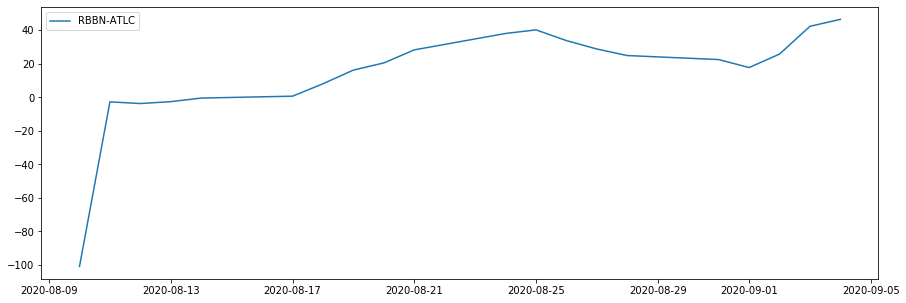

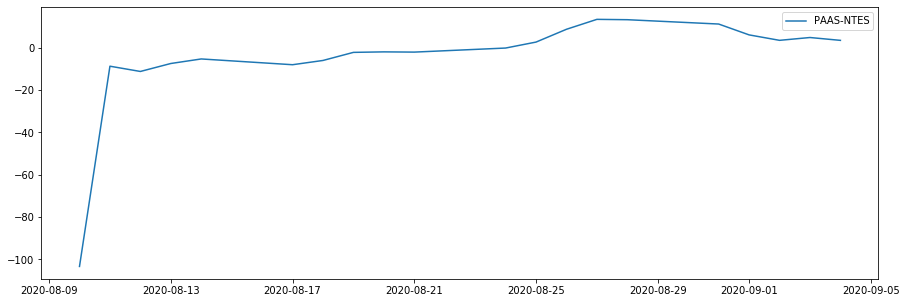

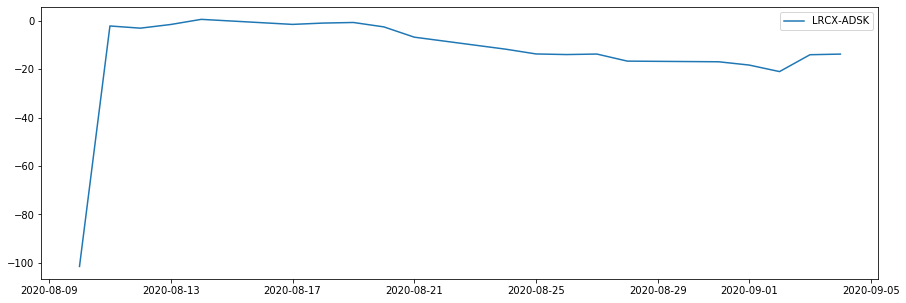

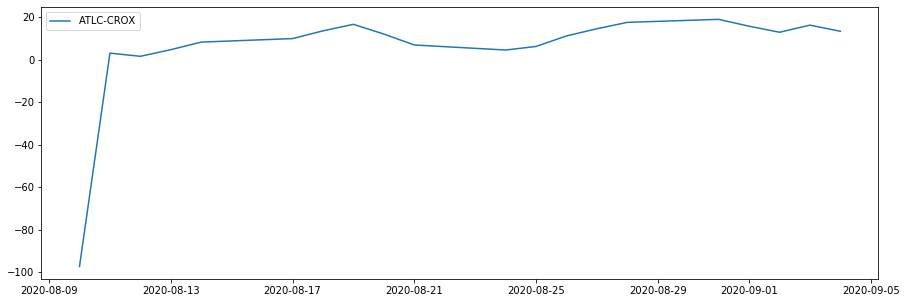

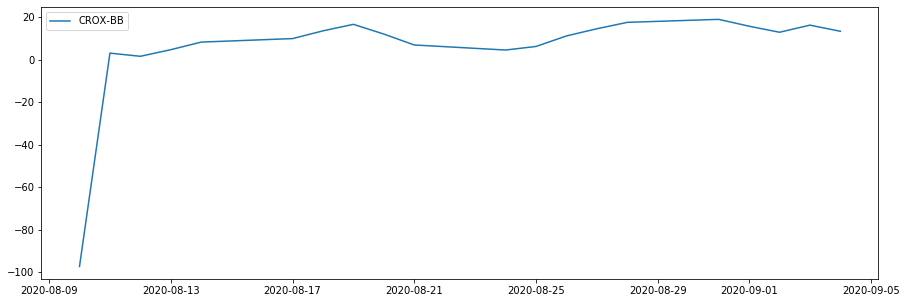

In [100]:
plt.figure(figsize = (15,5))
for n_ret, ret in enumerate(portfolio_returns):
    plt.figure(figsize = (15,5))
    plt.plot(price_test.index.to_timestamp()[price_test.shape[0]-len(portfolio_returns[0]):],
             pd.Series(ret).rolling(2).sum(), label = chosen_pairs[['pair']].iloc[n_ret,:][0])
    plt.legend();

In [ ]:
all_ret['PAAS']